# Query GPT

In [ ]:
import datetime
import os
import json
import shutil

from dotenv import load_dotenv
import base64
from openai import OpenAI
import cv2
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [4]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def log_query_contents(request_msg, request_img_path, response, log_dir_base="logs", log_dir_tail=""):
    """
    현재 날짜와 시간을 파일명으로 사용하여 메시지를 로깅합니다.
    
    Parameters:
    request_msg (list): 로깅할 request 메시지 콘텐츠
    request_img_path (str): 로깅할 request 이미지 경로
    response (ChatCompletion): API 응답 객체
    log_dir_base (str): 로그 파일이 저장될 base 디렉토리 (기본값: "logs")
    
    Returns:
    str: 생성된 로그 파일의 경로
    """
    # 로그 디렉토리가 없으면 생성
    if not os.path.exists(log_dir_base):
        os.makedirs(log_dir_base)
    
    # 현재 날짜와 시간을 가져와서 파일명 형식으로 변환
    current_time = datetime.datetime.now()
    timestamp = current_time.strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join(log_dir_base, f"{timestamp}{log_dir_tail}")
    os.makedirs(log_dir)
    
    request_filename = 'query_contents_request.txt'
    response_filename = 'query_contents_response.txt'
    
    # 전체 파일 경로 생성
    request_file_path = os.path.join(log_dir, request_filename)
    response_file_path = os.path.join(log_dir, response_filename)
    
    # 파일에 request 메시지 작성
    with open(request_file_path, "w", encoding="utf-8") as f:
        json.dump(request_msg, f, indent=4)

    # 이미지 저장
    if request_img_path and os.path.exists(request_img_path):
        filename = os.path.basename(request_img_path)
        destination = os.path.join(log_dir, filename)

        # 이미지 복사
        shutil.copy(request_img_path, destination)
    else:
        print("이미지 저장 실패 또는 이미지가 없습니다.")

    # ChatCompletion 객체를 직렬화 가능한 딕셔너리로 변환
    # OpenAI 응답 객체일 경우
    if hasattr(response, 'model_dump'):
        response_dict = response.model_dump()
    # 또는 딕셔너리 속성 접근이 가능한 경우
    elif hasattr(response, '__dict__'):
        response_dict = response.__dict__
    # 다른 방법으로도 안되면 문자열로 저장
    else:
        response_dict = {'response_str': str(response)}

    # 파일에 response 메시지 작성
    with open(response_file_path, "w", encoding="utf-8") as f:
        json.dump(response_dict, f, indent=4)

    return log_dir

## Step 1

In [84]:
step1_system_prompt = """You are a robot & simulation expert."""

step1_text_prompt = """Carefully analyze the given scene objects and task to extract the objects needed to simulate the task.
However, the objects to be extracted must be other than scene objects.
Your answer should be in JSON format. For example:
{{"target_objects": ["obj_0", "obj_1"]}}

Scene objects: {}
Task: {}
"""


In [116]:
# Load scene configs
scene = 'scene5'  #? Check
scene_info_filepath = f"imgs/img_info/{scene}.json"
with open(scene_info_filepath, 'r') as scene_f:
    scene_info = json.load(scene_f)
# print(scene_info.keys())

# Filter parenthesis
scene_objects = []
for caption in scene_info['captions']:
    parenthesis_start = caption.find('(')

    if parenthesis_start > 0:
        scene_object = caption[:parenthesis_start]
    else:
        scene_object = caption
    scene_objects.append(scene_object)

scene_objects_str = str(scene_objects).strip('[]')
print(f"scene_objects: {scene_objects}")
print(f"scene_objects_str: {scene_objects_str}")

scene_objects: ['locker']
scene_objects_str: 'locker'


In [117]:
# Fill text prompt
scene_objects = scene_objects_str  #? Check
task = "Open the cabinet next to the locker and give me the cup inside"  #?! Check

step1_text_prompt_filled = step1_text_prompt.format(scene_objects, task)

# Make request message
request_messages = [
        {
            "role": "system",
            "content": [{ "type": "text", "text": step1_system_prompt }]},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": step1_text_prompt_filled
                },
            ],
        }
    ]
#! Query GPT
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=request_messages,
    # temperature=0,  #? 0으로 해야하나?
)

# Response of the query
print(completion.choices[0].message.content)

# Log query instance
log_dir = log_query_contents(request_msg=request_messages, request_img_path="", response=completion, log_dir_tail="_step1")
print(f"저장 완료. {log_dir}")

```json
{"target_objects": ["cabinet", "cup"]}
```
이미지 저장 실패 또는 이미지가 없습니다.
저장 완료. logs/20250327_222329_step1


In [118]:
step1_res_str = completion.choices[0].message.content

# JSON 부분만 추출하기
# 문자열에서 json 부분 찾기
start_idx = step1_res_str.find('{')
end_idx = step1_res_str.rfind('}') + 1
step1_res_str = step1_res_str[start_idx:end_idx]

# JSON 문자열을 딕셔너리로 변환
step1_res = json.loads(step1_res_str)

# 결과 출력
print(step1_res)
print("Target objects:", step1_res["target_objects"])

{'target_objects': ['cabinet', 'cup']}
Target objects: ['cabinet', 'cup']


## Step 2

In [91]:
step2_system_prompt = """You are a professional simulation designer. The user will provide you with an annotated Scene image, a list of scene objects, objects to be placed, and a task.

First, carefully analyze the given task.
Then, understand the spatial relationships between objects through the Scene image and scene objects.
Next, based on your task analysis, determine the spatial relationships between the objects to be placed and the scene objects.
Finally, place the objects that need to be positioned in their optimal locations.

The output should be in JSON format.
"""

step2_text_prompt = """When there are objects to be placed, please tell me the appropriate location for each object based on the given scene and task.
I'll give you information about the scene as an image. The image has annotated scene objects.
The placement position should be determined based on a parent_object, and the parent_object must be chosen from either a scene object or one of the objects to be placed.
The position should be answered as one of ['above', 'below', 'left', 'right', 'front', 'back', 'inside'] relative to the parent_object.

Let me give you a concrete example:

Example Input:
Scene image: <image>
Scene objects: desk_0, drawer_0, notebook_0, notebook_1, monitor_0
Objects to be placed: ['pencil', 'pencil case']
Task: Take a pencil out of the pencil case on the desk.

Example Output:
{
		"target_objects": {
		    "pencil case": {
				"parent_object" : "desk_0",
				"placement" : "above"
		    },
			"pencil": {
				"parent_object" : "pencil case",
				"placement" : "inside"
			}
		}
}

Now look at the Scene image, Scene objects, Objects to be placed, and the Task to provide the correct answer.
Remember that parent_object can be used from not only scene objects but also from objects to be placed. And make sure the object placements are appropriate and well-aligned with the given task.
Scene image:
"""

step2_text_prompt2 = """Scene objects: {}
Objects to be placed: {}
Task: {}
"""

In [119]:
print(f"phrases: {scene_info['phrases']}")
print(f"scene_objects_str2: {scene_info['names']}")
print(f"objects to be placed: {step1_res['target_objects']}")
print(f"task: {task}")

phrases: ['locker']
scene_objects_str2: ['locker_0']
objects to be placed: ['cabinet', 'cup']
task: Open the cabinet next to the locker and give me the cup inside


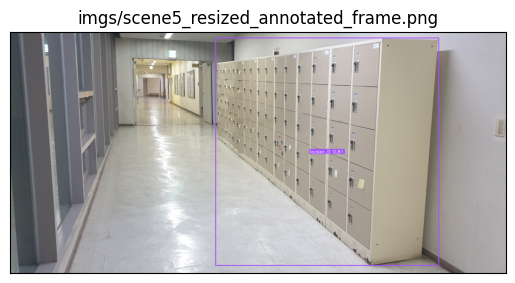

In [120]:
# annotated frame
annotated_frame_path = f"imgs/{scene}_resized_annotated_frame.png"
annotated_frame = cv2.imread(annotated_frame_path)
plt.title(f"{annotated_frame_path}")
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

```json
{
    "target_objects": {
        "cabinet": {
            "parent_object": "locker_0",
            "placement": "right"
        },
        "cup": {
            "parent_object": "cabinet",
            "placement": "inside"
        }
    }
}
```


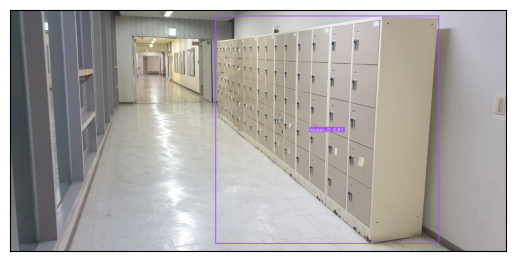

저장 완료. logs/20250327_222424_step2


In [121]:
# Fill text prompt
scene_objects = scene_info['names']  #? Check
objects_to_be_placed = step1_res['target_objects']  #? Check
task = task  #? Check

step2_text_prompt2_filled = step2_text_prompt2.format(scene_objects, objects_to_be_placed, task)

# Path to scene image
image_path = annotated_frame_path  #? Check
base64_image = encode_image(image_path)

request_messages = [
        {
            "role": "system",
            "content": [{ "type": "text", "text": step2_system_prompt }]},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": step2_text_prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                    }
                },
                {
                    "type": "text",
                    "text": step2_text_prompt2_filled
                }
            ],
        }
    ]


#! Query GPT
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=request_messages,
    # temperature=0,  #? 0으로 해야하나?
)

# Response of the query
print(completion.choices[0].message.content)

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

# Log query instance
log_dir = log_query_contents(request_msg=request_messages, request_img_path=image_path, response=completion, log_dir_tail="_step2")
print(f"저장 완료. {log_dir}")